<a href="https://colab.research.google.com/github/elopveg/Facturedo/blob/master/Facturedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/Base de datos/Facturedo'

test.csv  test_label.csv  train.csv  train_label.csv


In [ ]:
%cd '/content/drive/My Drive/Base de datos/Facturedo'

/content/drive/My Drive/Base de datos/Facturedo


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [ ]:
DataTrain = pd.read_csv('train.csv')
DataTrain

,Unnamed: 0,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,tcs37,tcs38,tcs39,tcs40,tcs41,tcs42,tc43,tc44,tc45,tc46,tc47,tc48,tc49,tc50,tc51,tc52,tc53,dv54,ae55,ae56,ae57,ae58,ae59,ae60,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70
0,1651,0.00,143270.10,100.0,0.0,0.0,63090564.44,4199850.00,0.00,6240000.0,17.0,643.0,6.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,3.259077e+05,15266089.96,8.0,1020.0,-0.633744,0.0,0.0,0.0,0.0,0.0,132,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1370,0.00,1403461.97,90.0,10.0,29.0,8013913.78,8177030.69,44951.90,0.0,12.0,475.0,6.0,5700426.25,0.0,0.0,20223.0,0.0,2.0,62781.08,0.00,62781.08,2.0,0.0,0.000000e+00,0.00,4.0,1290.0,6.699532,100.0,0.0,2.0,100.0,0.0,228,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2649,19800.24,63401.41,100.0,0.0,0.0,323384.60,67610.22,0.00,0.0,4.0,634.0,5.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,0.00,0.0,8.0,-0.503667,0.0,0.0,0.0,0.0,0.0,64,31.0,1.0,31.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,564,0.00,10585032.22,100.0,0.0,5.0,29596681.95,186964.54,0.00,4500000.0,11.0,649.0,6.0,3219970.31,0.0,0.0,0.0,0.0,0.0,0.00,604199.98,0.00,0.0,0.0,2.519000e+07,2559635.98,8.0,18.0,-1.970372,0.0,0.0,0.0,0.0,0.0,720,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2728,0.00,11259663.09,78.0,22.0,0.0,33626595.71,0.00,0.00,3972827.7,24.0,795.0,6.0,247181.79,0.0,0.0,848.0,848.0,0.0,0.00,0.00,0.00,0.0,0.0,3.084651e+04,16134256.08,0.0,487.0,-1.288042,0.0,100.0,0.0,0.0,0.0,968,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,2732,0.00,0.00,100.0,0.0,0.0,17321789.44,6502334.11,0.00,4800000.0,23.0,840.0,6.0,0.00,0.0,3673.0,0.0,3673.0,0.0,0.00,0.00,0.00,0.0,0.0,1.880433e+06,343517.06,0.0,628.0,-1.388930,0.0,100.0,0.0,0.0,0.0,6,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2185,2069,0.00,148821.45,100.0,0.0,5.0,17874738.23,805330.00,0.00,4279059.0,14.0,636.0,6.0,241573.49,0.0,0.0,0.0,0.0,0.0,0.00,184667.29,0.00,0.0,0.0,0.000000e+00,0.00,10.0,324.0,-1.150067,0.0,0.0,0.0,0.0,0.0,263,30.0,152.0,30.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2186,1018,0.00,6438.10,0.0,0.0,0.0,0.00,0.00,0.00,0.0,9.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,0.00,0.0,34.0,-0.339012,0.0,0.0,0.0,0.0,0.0,64,-3.0,-3.0,-3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2187,2323,0.00,1309077.66,91.0,9.0,12.0,7757433.99,9312203.53,19156.47,0.0,12.0,338.0,6.0,5150320.74,0.0,0.0,20223.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,0.00,8.0,1359.0,7.024467,100.0,0.0,0.0,0.0,0.0,197,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
LabelTrain = pd.read_csv('train_label.csv', names=['Pago'])
LabelTrain['Pago'] = LabelTrain['Pago'].astype(int)
LabelTrain

,Pago
0,0
1,1
2,1
3,0
4,1
...,...
2184,0
2185,0
2186,0
2187,1


In [ ]:
DataTest = pd.read_csv('test.csv')
DataTest

,Unnamed: 0,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,tcs37,tcs38,tcs39,tcs40,tcs41,tcs42,tc43,tc44,tc45,tc46,tc47,tc48,tc49,tc50,tc51,tc52,tc53,dv54,ae55,ae56,ae57,ae58,ae59,ae60,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70
0,2269,0.00,0.10,29.0,71.0,0.0,4.206076e+07,2445379.88,0.0,8000000.0,40.0,775.0,6.0,0.00,0.0,0.0,0.0,0.0,0.0,36011.71,66265.39,0.00,0.0,0.0,9.099982e+06,8.232633e+04,17.0,832.0,-1.379679,0.0,0.0,0.0,0.0,0.0,179,30.0,1.0,30.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2709,0.00,0.00,100.0,0.0,3.0,6.356591e+06,1151315.35,0.0,3798381.6,24.0,686.0,6.0,0.00,74.0,0.0,0.0,74.0,0.0,0.00,3681.60,0.00,0.0,1.0,0.000000e+00,0.000000e+00,2.0,11.0,-1.100000,0.0,100.0,1.0,0.0,100.0,10,31.0,93.0,31.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2345,0.00,0.00,100.0,0.0,0.0,1.834357e+08,8136692.18,0.0,8000000.0,8.0,659.0,6.0,2947178.08,0.0,0.0,0.0,0.0,8.0,0.00,216952.42,126547.08,0.0,11.0,9.269057e+06,8.963172e+07,1.0,14796.0,-1.042864,0.0,0.0,11.0,0.0,100.0,905,31.0,1.0,31.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2810,0.00,104207.83,100.0,0.0,0.0,7.515544e+07,4211350.00,0.0,6240000.0,17.0,727.0,6.0,0.00,39.0,0.0,0.0,39.0,0.0,0.00,0.00,0.00,0.0,0.0,3.259077e+05,2.076183e+07,10.0,1020.0,-0.633744,0.0,100.0,0.0,0.0,0.0,160,28.0,1.0,28.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1199,87791.71,460376.03,94.0,6.0,26.0,8.624776e+07,39737205.73,0.0,8000000.0,15.0,350.0,6.0,15023342.62,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.213933e+04,0.000000e+00,8.0,789.0,-1.079730,0.0,0.0,0.0,0.0,0.0,326,31.0,62.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,1425,0.00,813216.41,100.0,0.0,0.0,1.642559e+07,0.00,0.0,3071719.0,23.0,689.0,6.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,105000.00,0.00,0.0,0.0,4.854684e+04,1.322343e+07,0.0,185.0,-0.802372,0.0,0.0,0.0,0.0,0.0,474,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
544,223,0.00,39690.33,100.0,0.0,0.0,7.174000e+07,0.00,0.0,10000000.0,9.0,726.0,6.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.130976e+06,1.031949e+07,10.0,608.0,-1.330787,0.0,0.0,0.0,0.0,0.0,222,30.0,1.0,30.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
545,910,0.00,43754.09,100.0,0.0,0.0,9.366955e+07,0.00,0.0,0.0,45.0,824.0,6.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,7788.00,0.00,0.0,0.0,1.146960e+05,0.000000e+00,18.0,865.0,1.313994,0.0,0.0,0.0,0.0,0.0,295,30.0,1.0,30.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
546,2692,0.00,10484136.23,100.0,0.0,4.0,2.858129e+07,423747.53,0.0,4500000.0,11.0,622.0,6.0,2745701.28,0.0,0.0,0.0,0.0,0.0,0.00,604199.98,0.00,0.0,0.0,2.524332e+07,2.616488e+06,6.0,18.0,-1.937568,0.0,0.0,0.0,0.0,0.0,689,31.0,123.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
LabelTest = pd.read_csv('test_label.csv',names=['Pago'])
LabelTest['Pago'] = LabelTest['Pago'].astype(int)
LabelTest

,Pago
0,0
1,0
2,0
3,0
4,1
...,...
543,0
544,0
545,0
546,0


In [ ]:
print(pd.value_counts(LabelTrain['Pago'], sort = True))

0    1760
1     429
Name: Pago, dtype: int64


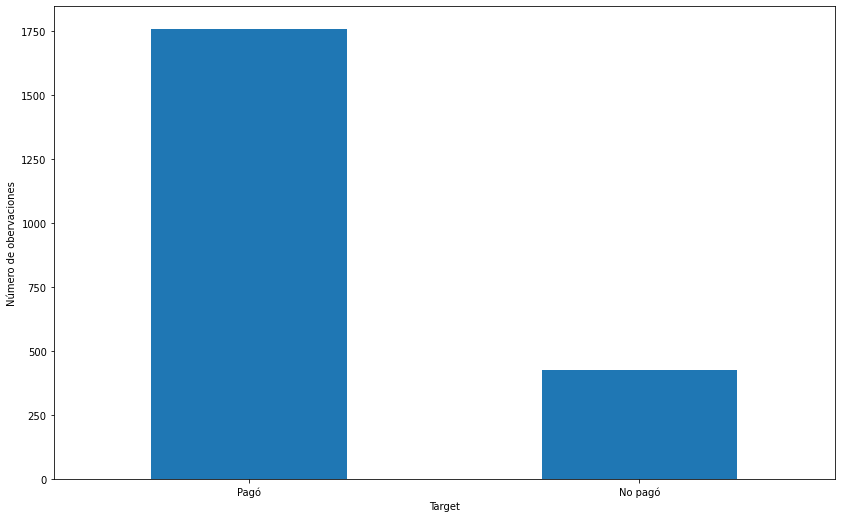

In [ ]:
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Pagó","No pagó"]
count_classes = pd.value_counts(LabelTrain['Pago'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.xlabel("Target")
plt.ylabel("Número de obervaciones");

**Efectivamente se ve que el conjunto de datos está desbalanceado**

Ya que hay mas eventos que fueron pagados a tiempo que los no pagados a tiempo

**Cuando se haga la predicción es muy probable que no sea tan robusto, justamente por este desbalance**

***A continuación se verá el modelo sin aplicar ningún tipo balance:***

In [ ]:
X_train = DataTrain
X_test = DataTest
y_train = LabelTrain
y_test = LabelTest

In [ ]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base
  
def mostrar_resultados(y_test, pred_y,y_train,pred_y_train):
    conf_matrix = confusion_matrix(y_test, pred_y)
    auctest = roc_auc_score(y_test, pred_y)
    auctrain = roc_auc_score(y_train, pred_y_train)
    ginitest = auctest*2 - 1
    ginitrain = auctrain*2-1
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test, pred_y))
    print('Gini Test: ',ginitest)
    print('Gini Train: ',ginitrain)

In [ ]:
def plot_roc_curve(y_true, y_score, filepath=None, line_width=2, width=8,
                   height=6, title=None, colors=("#FF0000", "#000000")):

    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    auc = roc_auc_score(y_true, y_score)
    gini = auc*2 - 1

    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(width, height))
    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="both", axis="both")
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)
    ax.tick_params(which="major", direction="out", length=5)
    plt.plot(fpr, tpr, color=colors[0], lw=line_width,
                   label="ROC curve (gini = {:.2f})".format(gini))
    plt.plot([0, 1], [0, 1], color=colors[1], lw=line_width, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel("False positive rate", fontsize=15)
    plt.ylabel("True positive rate", fontsize=15)
    if title:
        plt.title(title, fontsize=30, loc="left")
    plt.legend(loc="lower right", frameon=True, fontsize="xx-large",
                     fancybox=True)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=200)
        plt.close()
    else:
        plt.show()

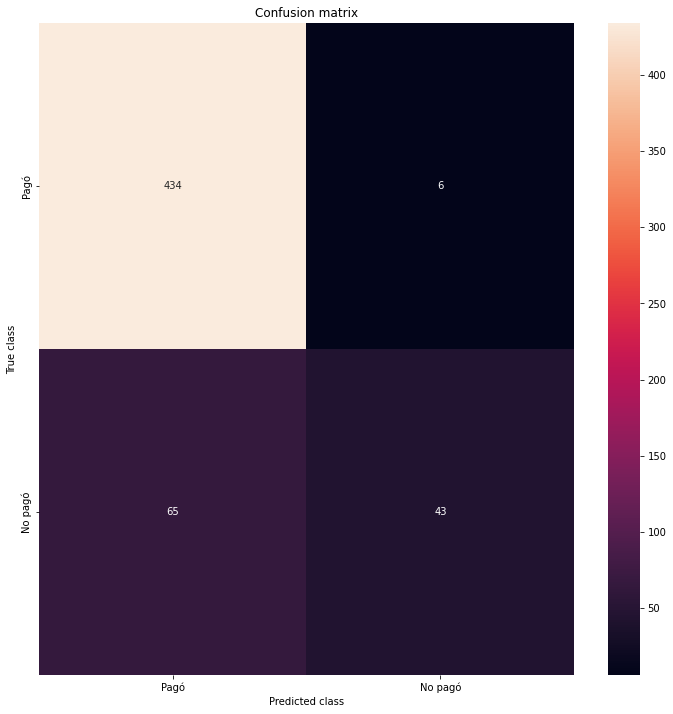

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       440
           1       0.88      0.40      0.55       108

    accuracy                           0.87       548
   macro avg       0.87      0.69      0.74       548
weighted avg       0.87      0.87      0.85       548

Gini Test:  0.38451178451178447
Gini Train:  0.29514860139860133


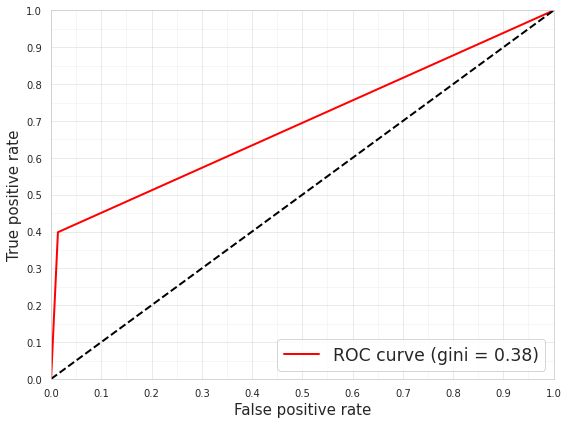

In [ ]:
model = run_model(X_train, X_test, y_train, y_test)
pred_y_test = model.predict(X_test)
pred_y_train = model.predict(X_train)

mostrar_resultados(y_test, pred_y_test, y_train, pred_y_train)
plot_roc_curve(y_test, pred_y_test)



---


**En la matriz de confusión , la clase "No pagó (1)" (Es la clase que interesa detectar ya que son los que no pagan el crédito a tiempo ) hay  65 fallos y 43 aciertos. Esto representa un  recall de 0.40 y es el valor que se quiere mejorar. En la columna de f1-score se obtiene un 0.55 para la clase "no pagó", esto se debe a que a pesar de tener una buena precisión (0.88) no se tiene buen recall, si solo se ve el valor de la precisión sería engañoso, pues está reflejando una realidad parcial.** 

**Comparando f1-score de los casos potivios y negativos se concluye que la data necesita usar algoritmos de balanceo, ya que el modelo no predice bien los no pagados a tiempo, que es la clase minoritaria**

**Por tanto, el modelo no es capaz de detectar correctamente los casos de no pago a tiempo.**

**El Gini es 0.3845 indica que el modelo planteado tal como está no distingue bien entre los buenos y malos clientes**


---



***Entonces, el objetivo será tratar de evitar esta desventaja del desbalance de datos entre los que pagan y no el crédito a tiempo , para ello se aplicará diferentes métodos para ver y evaluar cúal es el más adecuado.***


---



In [ ]:
sm_to = SMOTETomek(ratio=0.5)
X_train_resST, y_train_resST = sm_to.fit_sample(X_train, y_train)
print ("Distribution after resampling {}".format(Counter(y_train_resST)))

Distribution after resampling Counter({0: 1691, 1: 811})




---


**Lo que se ha hecho es utilizar el algoritmo SMOTETomek que consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling a la vez al dataset. En este caso se ha reducido de 1760 muestras de clase cero (la clase mayoritaria) a 1687, y a aumentado la clase uno a (807) y con esas muestras se entrena el modelo.**

---



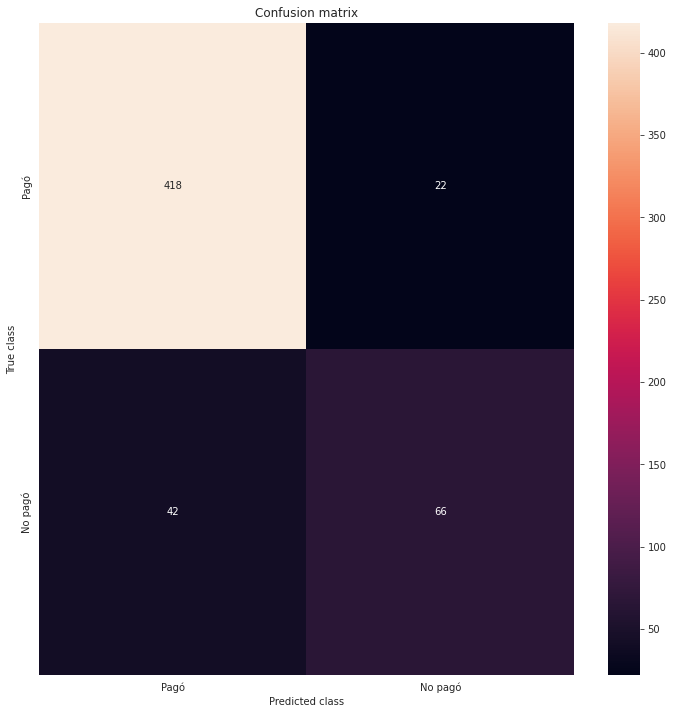

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       440
           1       0.75      0.61      0.67       108

    accuracy                           0.88       548
   macro avg       0.83      0.78      0.80       548
weighted avg       0.88      0.88      0.88       548

Gini Test:  0.5611111111111109
Gini Train:  0.46027097902097913


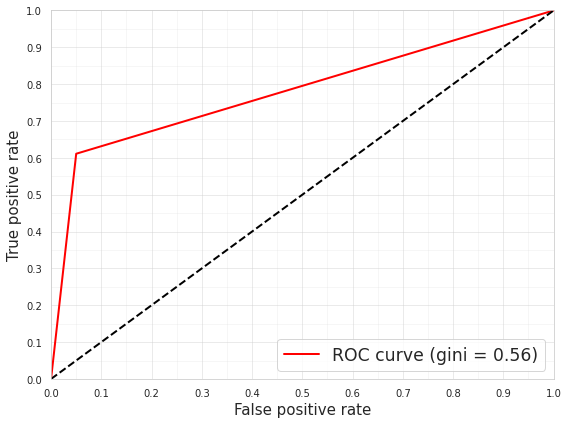

In [ ]:
modelST = run_model(X_train_resST, X_test, y_train_resST, y_test)
pred_y_testST = modelST.predict(X_test)
pred_y_trainST = modelST.predict(X_train)

mostrar_resultados(y_test, pred_y_testST,y_train,pred_y_trainST)
plot_roc_curve(y_test, pred_y_testST)



---


**En la matriz de confusión , la clase "No pagó (1)" (Es la clase que interesa detectar ya que son los que no pagan a tiempo ) hay  41 fallos y 67 aciertos. Esto representa un  recall de 0.61. En la columna de f1-score se obtiene 0.93 (detección de 0s) y 0.67 (detcción de 1s), 0.67 se debe a que a pesar de subir el recall ha bajado la presición por lo tanto el modelo aún no ha mejorado lo suficiente en detectar la clase minoritaria muy bien** 


**El Gini es 0.56 mejora con respecto a lo obtenido anteriormente**

Sin embargo en cada iteración SMOTETomek estos valores irán cambiando.



---


---


**Existen otros algoritmos como el caso anterior como:** 

*   **NearMiss:** consiste en reducir la clase mayoritaria.
*   **RandomOverSampler:** que consiste en crear muestras nuevas “sintéticas” de la clase minoritaria.

***Sin embargo seguirán saliendo parecido al caso anterior, ya que tienen casi la misma lógica, por ello se aplicará algo diferente. Tal como se ve en los siguientes casos:***

---

In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1,penalty='l2',solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf



---


**En este caso se utiliza un parámetro adicional en el modelo de Regresión logística en donde indicamos weight = “balanced” y con esto el algoritmo se encargará de equilibrar a la clase minoritaria durante el entrenamiento**

---



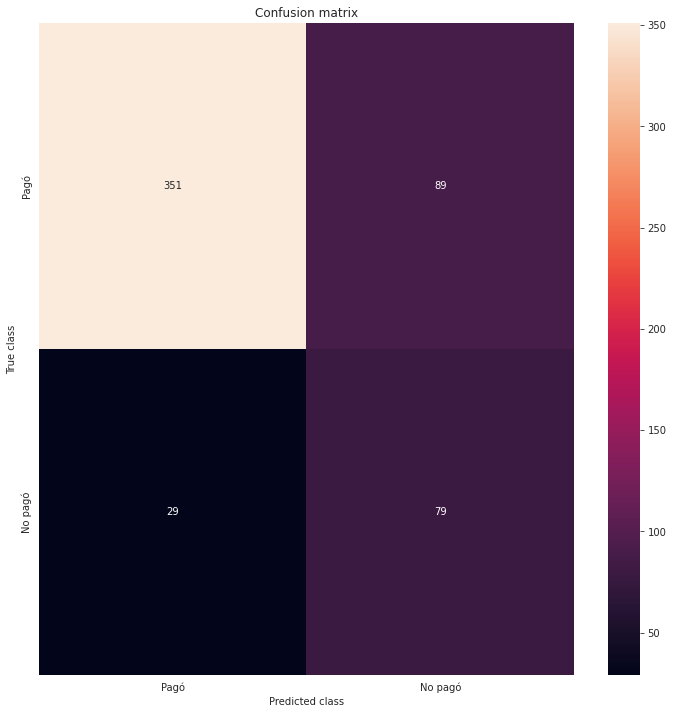

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       440
           1       0.47      0.73      0.57       108

    accuracy                           0.78       548
   macro avg       0.70      0.76      0.71       548
weighted avg       0.83      0.78      0.80       548

Gini Test:  0.529208754208754
Gini Train:  0.4659819347319347


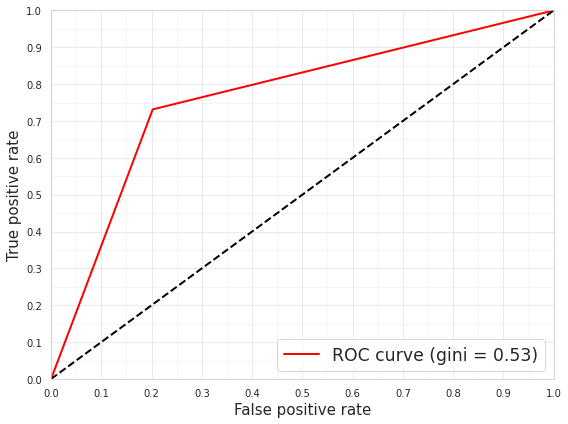

In [ ]:
balanced_model = run_model_balanced(X_train, X_test, y_train, y_test)
pred_y_trainbm = balanced_model.predict(X_train)
pred_y_testbm = balanced_model.predict(X_test)
mostrar_resultados(y_test, pred_y_testbm,y_train,pred_y_trainbm)
plot_roc_curve(y_test, pred_y_testbm)

In [ ]:
grid = [i for i in range(1, 11, 1)]
param_grid = {'C': [np.round((0.1*i), decimals =2) for i in grid]}
print('Parameters:', param_grid)


Parameters: {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [ ]:
from sklearn.model_selection import GridSearchCV

clfGS = GridSearchCV(LogisticRegression(penalty='l2',class_weight="balanced",solver="newton-cg"), 
                   param_grid = param_grid, verbose=0, return_train_score=True, 
                   n_jobs=-1, cv=5)


---

**Se utiliza el parámetro weight = “balanced” en el modelo de Regresión con lo que se equilibrará a la clase minoritaria durante el entrenamiento, además se usa GridSearchCV para optimizar el hiperparámetro C de la regresión Logística**

---

In [ ]:
clfGS.fit(X_train, y_train) 
print('Best Params:', clfGS.best_params_, '\n')

Best Params: {'C': 0.7} 



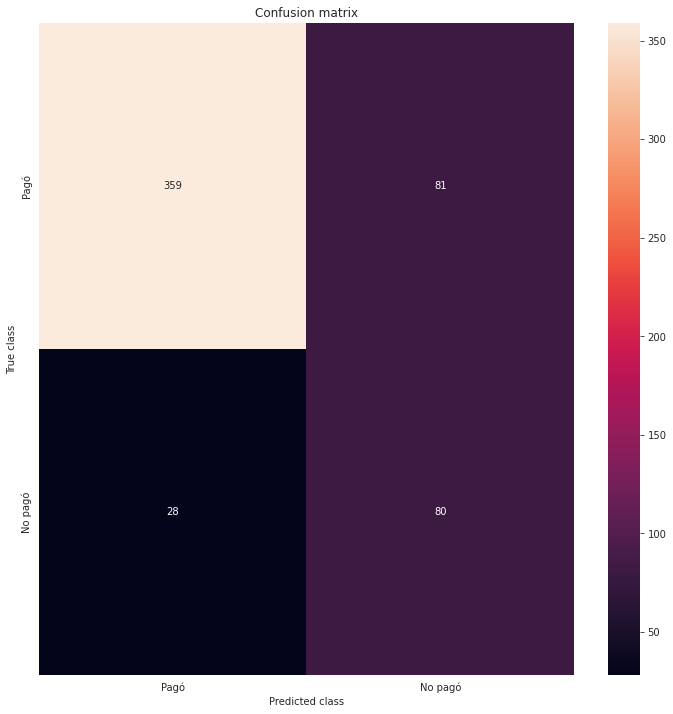

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       440
           1       0.50      0.74      0.59       108

    accuracy                           0.80       548
   macro avg       0.71      0.78      0.73       548
weighted avg       0.84      0.80      0.81       548

Gini Test:  0.5566498316498318
Gini Train:  0.47865675990675993


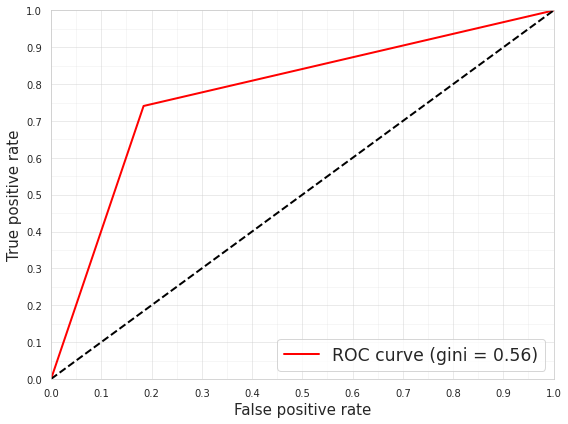

In [ ]:
pred_ytestGS = clfGS.predict(X_test)
pred_ytraintGS = clfGS.predict(X_train)
mostrar_resultados(y_test, pred_ytestGS,y_train,pred_ytraintGS)
plot_roc_curve(y_test, pred_ytestGS)


---


**En los dos últimos modelos anteriores se tiene lo siguiente:**



*   **Si solo se balancea el dataset con el parámetro weight = “balanced”, no se tiene mejoras con los modelos anteriormente ejecutados**

*   **Si se optimiza el hiperparámetro C, un parámetro que aplica regularización con el objetivo de reducir el overfitting con ello mejora el modelo:**

1.   **La clase "No pagó (1)" (Es la clase que interesa detectar, los que no pagan a tiempo) hay  28 fallos y 80 aciertos, esto representa un  recall de 0.74.**

2.   **En la columna de f1-score se obtiene 0.87 (detección de 0s) y 0.59(detcción de 1s), 0.59 es porque que a pesar de haber mejorado el recall a 0.74 se ha bajado en la presición a 0.50**

3. **El Gini sube a 0.56 lo cual puede decir que ha mejorado la detección de los que no pagan a tiempo**



---


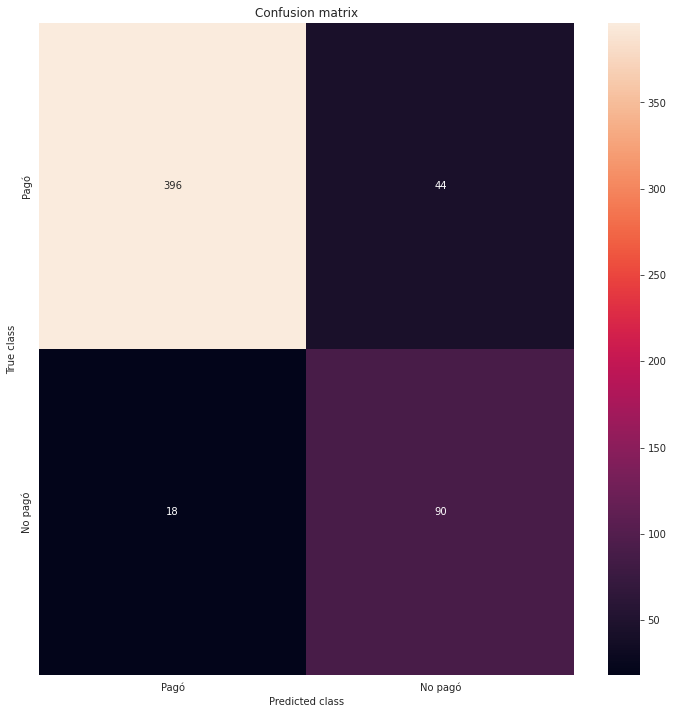

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       440
           1       0.67      0.83      0.74       108

    accuracy                           0.89       548
   macro avg       0.81      0.87      0.84       548
weighted avg       0.90      0.89      0.89       548

Gini Test:  0.7333333333333334
Gini Train:  0.9315850815850815


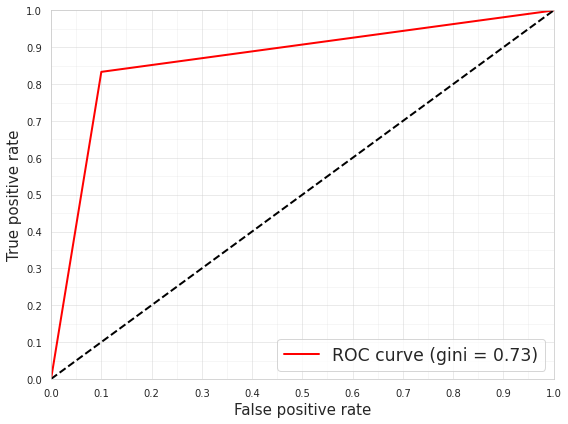

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=123)
 
#Train the classifier.
bbc.fit(X_train, y_train)
pred_y_testBBC = bbc.predict(X_test)
pred_y_trainBBC = bbc.predict(X_train)

mostrar_resultados(y_test, pred_y_testBBC,y_train,pred_y_trainBBC)
plot_roc_curve(y_test, pred_y_testBBC)

---


**Este último modelo es claramente superior a los demás, se usa BalancedBaggingClassifier que consiste en sobremuestrear la clase mayoritaria, reducir la varianza, balancear el dataset y evitar el sobreajuste. Se tiene los siguientes resultados:**


1.   **La clase "No pagó (1)" (Es la clase que interesa detectar, los que no pagan a tiempo) hay  18 fallos y 90 aciertos, mucho mejor que los modelos anteriores, esto representa un  recall de 0.83.**

2.   **En la columna de f1-score se obtiene 0.93 (detección de 0s) y 0.74(detección de 1s), se observa una mejora**

3. **El Gini sube a 0.73 lo cual refleja la mejora de la detección, de los que no pagan el crédito a tiempo, sin embargo al comparar con el gini obtenido en el entranamiento (train) y en test, se observa sobreajuste (overfitting), ya que pasa de un gini=0.93 en el train a gini=0.73 en el test**


---




In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


bc_params = {"base_estimator__max_depth": [9,10,11],
          "base_estimator__max_features": [None,"auto"],
          "base_estimator__min_samples_leaf": [1,2,3,4],
          "base_estimator__min_samples_split": [4,5,6],
          'bootstrap_features': [False,True],
          'max_features': [0.8,0.9,1,1.2],
          'max_samples': [0.5,0.9,1.0,1.2],
          'n_estimators': [49,50,51],
}



bc_gs = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), bc_params, cv=5, verbose=1)



---


**Por último se ha usado GridSearchCV para buscar los hiperparámetros más adecuados para el árbol de desición usando el clasificador Bagging, a continuación se entrena el modelo:**


---





In [ ]:
bc_gs.fit(X_train, y_train) 
print('Best Params:', bc_gs.best_params_, '\n')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.5min finished


Best Params: {'base_estimator__max_depth': 11, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 6, 'bootstrap_features': False, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 49} 



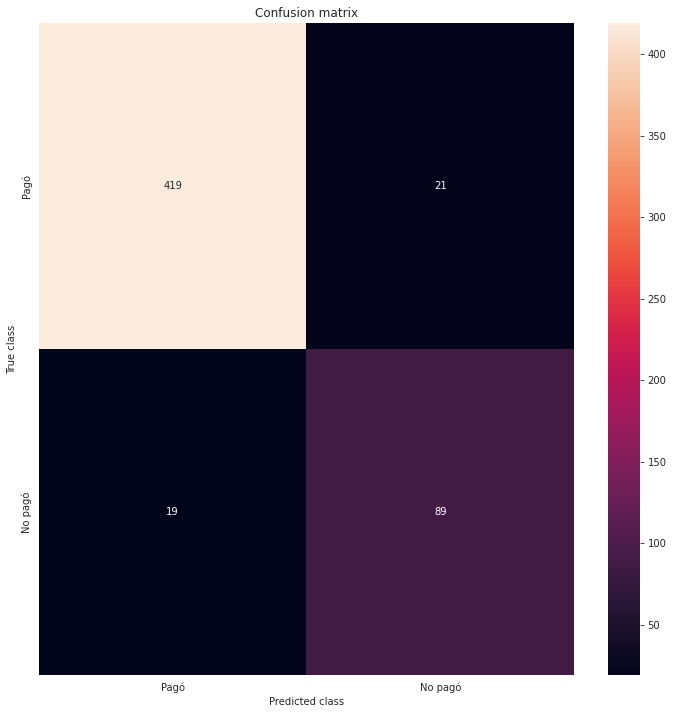

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       440
           1       0.81      0.82      0.82       108

    accuracy                           0.93       548
   macro avg       0.88      0.89      0.89       548
weighted avg       0.93      0.93      0.93       548

Gini Test:  0.7763468013468013
Gini Train:  0.9089889277389276


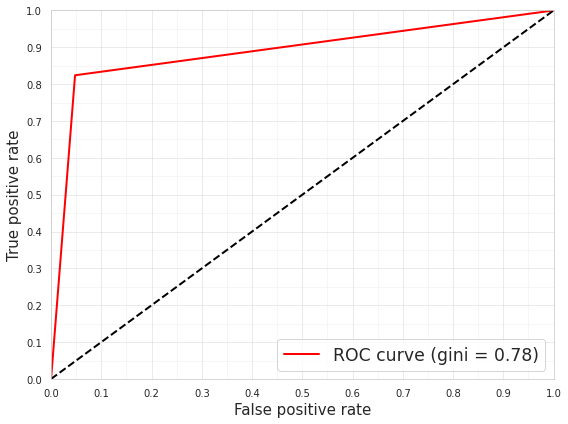

In [ ]:
pred_y_testgs = bc_gs.predict(X_test)
pred_y_traings = bc_gs.predict(X_train)
mostrar_resultados(y_test, pred_y_testgs, y_train, pred_y_traings)

plot_roc_curve(y_test, pred_y_testgs)

---


**Este último modelo mejora la presición obtenido anteriormente, por ello se tiene lo siguiente:**


1.   **La clase "No pagó (1)" (Es la clase que interesa detectar, los que no pagan a tiempo) hay  19 fallos y 89 aciertos, esto representa un  recall de 0.82.**

2.   **En la columna de f1-score se obtiene 0.95 (detección de 0s) y 0.82(detección de 1s), se observa una mejora al modelo anterior, y se debe a que ahora predice mejor los casos positivos de pago**

3. **El Gini sube a 0.78 lo cual refleja la mejora de la detección de los pagan y los que no pagan el crédito a tiempo, también baja el sobreajuste que se vió solo aplicando BalancedBaggingClassifier**

**CONCLUSIÓN:** *este modelo sería el más adecuado para usarlo en producción, debido a que tiene un recall parecido al modelo usando BalancedBaggingClassifier pero se tiene un mejor precisión*

---

**NOTA**

1.   **El modelo puede mejorar aún más haciendo un tratamiendo de las variables independientes del dataset, que en este caso no se ha hecho debido a que no se conoce el significado de ninguno de ellos.**



